In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib.gridspec as gridspec
from cmath import rect
import control
import math
import pylab
pylab.rcParams['figure.figsize'] = 10, 5

Fit to a transfer function

In [2]:
def bode (f, R_ohm, R_TE, C_TE):
    # H = R_ohm + R_TE/(C_TE*R_TE*s+1)
    # H = signal.lti([R_ohm*R_TE*C_TE,R_ohm+R_TE], [C_TE*R_TE, 1])
    num = [R_ohm*R_TE*C_TE, R_ohm+R_TE]
    den = [C_TE*R_TE, 1]
    H = signal.TransferFunction(num, den)
    w, mag, phase = signal.bode(H, [2*np.pi*freq for freq in f])
    mag = [10**(dBmag/20) for dBmag in mag]
    nprect = np.vectorize(rect)
    X_jY = nprect(mag, np.deg2rad(phase))
    return np.stack([np.real(X_jY ), np.imag(X_jY )], axis=-1)

Parse and trim datafile

In [3]:
def parse_data (datfilename, freqLB, freqUB):

    datapoints = []
    freq = []
    X = []
    Y = []
    R = []
    P = []

    lines = open(datfilename, 'r')

    for line in lines:
        try:
            datapoints.append(line.rstrip())
            f = float(line.split()[5])
            assert (f >= freqLB and f <= freqUB)
            freq.append(f)
            
    #         X.append(float(line.split()[1]))
    #         Y.append(float(line.split()[2]))
            R.append(float(line.split()[3]))
            P.append(float(line.split()[4]))
            
        except:
            pass
        
    Pmin = min(P)
        
    if len(X)<len(R):
        for magnitude, phase, f in zip(R, P, freq):
            real = magnitude * np.cos(phase*np.pi/180)
            img = magnitude * np.sin(phase*np.pi/180)
            X.append(real)
            Y.append(img)
            if Pmin == phase:
                est_f_TE = f
                
    return np.array(X), np.array(Y), np.array(R), np.array(P), np.array(freq), est_f_TE

In [4]:
X, Y, R, P, freq, est_f_TE = parse_data("FourPointWires.dat", 12, 1e4)

#### Optimizers

’leastsq’: Levenberg-Marquardt (default)

’least_squares’: Least-Squares minimization, using Trust Region Reflective method

’differential_evolution’: differential evolution

’brute’: brute force method

’basinhopping’: basinhopping

’ampgo’: Adaptive Memory Programming for Global Optimization

’nelder’: Nelder-Mead

’lbfgsb’: L-BFGS-B

’powell’: Powell

’cg’: Conjugate-Gradient

’newton’: Newton-CG

’cobyla’: Cobyla

’bfgs’: BFGS

’tnc’: Truncated Newton

’trust-ncg’: Newton-CG trust-region

’trust-exact’: nearly exact trust-region

’trust-krylov’: Newton GLTR trust-region

’trust-constr’: trust-region for constrained optimization

’dogleg’: Dog-leg trust-region

’slsqp’: Sequential Linear Squares Programming

’emcee’: Maximum likelihood via Monte-Carlo Markov Chain

’shgo’: Simplicial Homology Global Optimization

’dual_annealing’: Dual Annealing optimization

In [5]:
def fit_data(X, Y, est_f_TE, model = bode, confidence = 1.02, minimizer = "leastsq"):
        
        # initial guess
        est_R_ohm = min(X)
        est_R_TE = max(X)-est_R_ohm
        est_C_TE = 1/(est_f_TE*2*np.pi)/est_R_TE

        # pass 1d array to avoid complex part being trimmed by scipy
        X_jY = np.zeros_like(X, dtype=np.complex)
        X_jY = np.array([x+1j*y for (x, y) in zip(X,Y)])
        X_jY_flattened = np.stack([np.real(X_jY), np.imag(X_jY )], axis=-1)
        
        bode_model = Model(bode)
        bode_model.set_param_hint('C_TE', value=est_C_TE, min=est_C_TE/confidence,max=est_C_TE*confidence)
        bode_model.set_param_hint('R_ohm', value=est_R_ohm, min=est_R_ohm/confidence,max=est_R_ohm*confidence)
        bode_model.set_param_hint('R_TE', value=est_R_TE, min=est_R_TE/confidence,max=est_R_TE*confidence)
        
        params = bode_model.make_params(R_ohm = est_R_ohm, R_TE=est_R_TE, C_TE=est_C_TE)
        
        print('---------------------------REPORT-----------------------------')
        print("[[Confidence]] = {}\n[[Minimizer]] = {}".format(confidence, minimizer))
        Z_fit_obj = bode_model.fit(X_jY_flattened, params, f=freq, method=minimizer) #
               
        print('[[zT initialguess]] = R_TE/R_ohm = '+str((est_R_TE)/est_R_ohm))

        
        initial_fit = Z_fit_obj.init_fit
        initial_fit = initial_fit[:, 0] + 1j*initial_fit[:, 1]
        Z_fit = Z_fit_obj.best_fit    
        Z_fit = Z_fit[:, 0] + 1j*Z_fit[:, 1]
        print(Z_fit_obj.fit_report())
        
        
        est_R_ohm = Z_fit_obj.params['R_ohm'].value
        est_R_TE = Z_fit_obj.params['R_TE'].value
        est_C_TE = Z_fit_obj.params['C_TE'].value
        est_f_TE=1/2/np.pi/est_R_TE/est_C_TE
        
        print('[[Predictions]]')
        print('zT = R_TE/R_ohm = '+str(est_R_TE/est_R_ohm))
        print('R_ohm = {}'.format(est_R_ohm))
        print('R_TE = {}'.format(est_R_TE))
        print('C_TE = {}'.format(est_C_TE))
        print('f_TE = '+str(est_f_TE))
        print('f lim -> 0 dashed line = est_R_ohm+est_R_TE = '+str((est_R_ohm+est_R_TE)))
        print('f lim -> inf dashed line = est_R_ohm ='+str(est_R_ohm))
        
        return Z_fit, initial_fit, est_R_ohm, est_R_TE, est_C_TE, est_f_TE
        


In [6]:
Z_fit, initial_fit, est_R_ohm, est_R_TE, est_C_TE, est_f_TE = fit_data(X, Y, est_f_TE, minimizer = "emcee")
bool_curvefit = True

  0%|                                                                                                                            | 0/1000 [00:00<?, ?it/s]

---------------------------REPORT-----------------------------
[[Confidence]] = 1.02
[[Minimizer]] = emcee


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.55it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [43.46441975 49.38557907 42.21208434]
[[zT initialguess]] = R_TE/R_ohm = 0.046928365509854394
[[Model]]
    Model(bode)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 834
    # variables        = 3
    chi-square         = 1.1031e-07
    reduced chi-square = 1.3275e-10
    Akaike info crit   = -18964.3182
    Bayesian info crit = -18950.1395
[[Variables]]
    R_ohm:  0.00746526 +/- 9.7858e-05 (1.31%) (init = 0.007465094)
    R_TE:   3.5054e-04 +/- 4.7626e-06 (1.36%) (init = 0.0003503247)
    C_TE:   0.34283422 +/- 0.00456582 (1.33%) (init = 0.3429508)
[[Predictions]]
zT = R_TE/R_ohm = 0.04695581793995973
R_ohm = 0.007465264340247315
R_TE = 0.0003505375932343265
C_TE = 0.3428342194655826
f_TE = 1324.3457046455815
f lim -> 0 dashed line = est_R_ohm+est_R_TE = 0.00781580

Text(0.5, 1.0, 'Impedance spectrum')

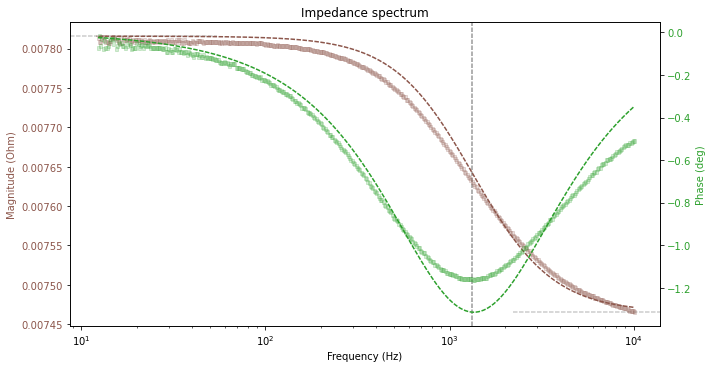

In [7]:
fig, ax1 = plt.subplots(1)
ax2 = ax1.twinx()
ax1.set_xlabel('Frequency (Hz)')
plt.xscale('log')
color = 'tab:brown'
ax1.set_ylabel('Magnitude (Ohm)', color=color)

if bool_curvefit: 
    ax1.axhline(y=est_R_ohm, dashes=[3, 1], color='0.8', xmin=0.75, xmax=1)
    ax1.axhline(y=est_R_ohm+est_R_TE, dashes=[3, 1], color='0.8', xmin=0, xmax=0.25)
    ax1.axvline(x=est_f_TE, dashes=[3, 1], color='0.6')
    ax1.plot(freq, R, marker='$.$', color=color, alpha=0.2, linestyle='None')
    ax1.plot(freq, np.abs(Z_fit), dashes=[3, 1], color=color)
#     ax1.plot(freq, np.abs(initial_fit), dashes=[3, 1], color=color, alpha=0.25)
else:
    ax1.plot(freq, R, marker='$.$', dashes=[3, 1], color=color)
ax1.tick_params(axis='y', labelcolor=color)
    
color = 'tab:green'
ax2.set_ylabel('Phase (deg)', color=color)
        
if bool_curvefit:
    ax2.plot(freq, P, marker='$.$', color=color, alpha=0.2, linestyle='None')
    ax2.plot(freq, np.angle(Z_fit, deg=True), dashes=[3, 1], color=color)
#     ax2.plot(freq, np.angle(initial_fit, deg=True), dashes=[3, 1], color=color, alpha=0.25)
else:
    ax2.plot(freq, P, marker='$.$', dashes=[3, 1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Impedance spectrum')

Text(0.5, 1.0, 'Impedance spectrum')

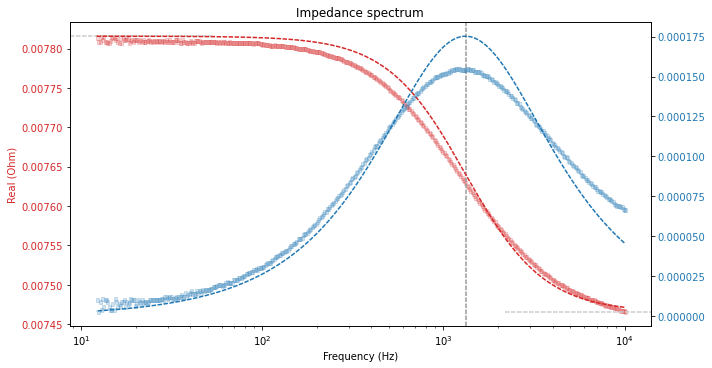

In [8]:
fig, ax3 = plt.subplots(1)
ax4 = ax3.twinx()
ax3.set_xlabel('Frequency (Hz)')
plt.xscale('log')

color = 'tab:red'
ax3.plot(freq, X, marker='$.$', color=color, alpha=0.2, linestyle='None', label='real')
ax3.set_ylabel('Real (Ohm)', color=color)
ax3.tick_params(axis='y', labelcolor=color)
if bool_curvefit:
    ax3.axvline(x=est_f_TE, dashes=[3, 1], color='0.6')
    ax3.axhline(y=est_R_ohm, dashes=[3, 1], color='0.8', xmin=0.75, xmax=1)
    ax3.axhline(y=est_R_ohm+est_R_TE, dashes=[3, 1], color='0.8', xmin=0, xmax=0.25)
    ax3.plot(freq, np.real(Z_fit), dashes=[3, 1], color=color, label='Final real fit')
#     ax3.plot(freq, np.real(initial_fit), dashes=[3, 1], color=color, label='Initial real fit', alpha=0.25)
else:
    ax3.plot(freq, X, dashes=[3, 1], color=color)
    
ax4.tick_params(axis='y')
color = 'tab:blue'
ax4.plot(freq, (-1)*Y, marker='$.$', color=color, alpha=0.2, linestyle='None', label='neg imaginary')
if bool_curvefit:
    ax4.plot(freq, (-1)*np.imag(Z_fit), dashes=[3, 1], color=color, label='Final neg img fit')
#     ax4.plot(freq, (-1)*np.imag(initial_fit), dashes=[3, 1], color=color, label='Initial neg img fit', alpha=0.25)
else:
    ax4.plot(freq, (-1)*Y, dashes=[3, 1], color=color)
    ax4.set_ylabel('Negative Imaginary (Ohm)', color=color)
ax4.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Impedance spectrum')

Text(0.5, 0, 'Real (Ohm)')

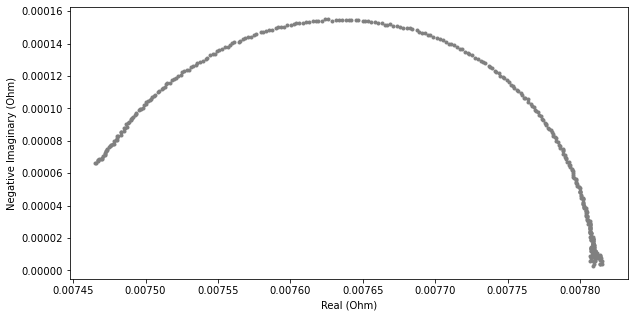

In [9]:
fig, axNyquist = plt.subplots(1)
plt.scatter(X, -1*Y, marker=".", color="0.5")
axNyquist.set_ylabel('Negative Imaginary (Ohm)')
axNyquist.set_xlabel('Real (Ohm)')